# Praca domowa 7
### Paulina Jaszczuk

## Import pakietów

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from math import floor, ceil
import copy
import warnings
warnings.filterwarnings('ignore')

## Import danych

In [163]:
train = pd.read_csv("C:\\Users\\pauli\\WUM\\hw7\\train.csv")
val = pd.read_csv("C:\\Users\\pauli\\WUM\\hw7\\val.csv")
test = pd.read_csv("C:\\Users\\pauli\\WUM\\hw7\\test.csv")
test_y = pd.DataFrame(test.iloc[:, 0])
test_x = test.iloc[:, 1:]
train.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,12.72,1.75,2.28,22.5,84,1.38,1.76,0.48,1.63,3.30,0.88,2.42,488
1,13.23,3.30,2.28,18.5,98,1.80,0.83,0.61,1.87,10.52,0.56,1.51,675
2,12.58,1.29,2.10,20.0,103,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640
3,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510
4,13.84,4.12,2.38,19.5,89,1.80,0.83,0.48,1.56,9.01,0.57,1.64,480


## Znalezienie optymalnej liczby klastrów

In [136]:
# funkcja klasteryzuje dane metodą GMM
def GMM_clustering(X, n_components, covType):
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=covType)
    gmm.fit(X)
    if hasattr(gmm, 'labels_'):
        y_pred = gmm.labels_.astype(np.int)
    else:
        y_pred = gmm.predict(X)
    return X, y_pred

In [135]:
# funckja oblicza wartości Silhuette Score:
def comparison(df, n_components, covType):
  silhouette = []
  for i in n_components:
    x = GMM_clustering(df, i, covType)
    silhouette.append(silhouette_score(*x))
  plt.plot(n_components, silhouette)
  plt.xlabel('number of clusters')
  plt.ylabel('Silhouette score')
  plt.show()

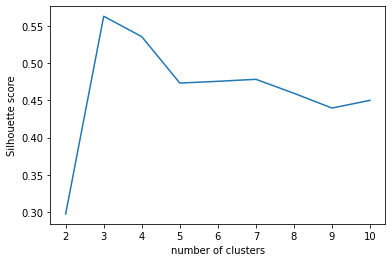

In [137]:
comparison(train, np.arange(2,11), 'full')

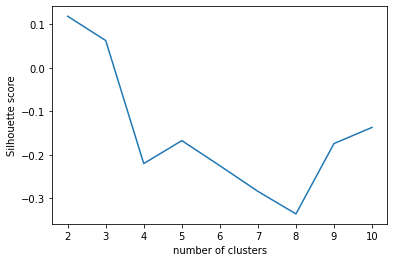

In [138]:
comparison(train, np.arange(2,11), 'diag')

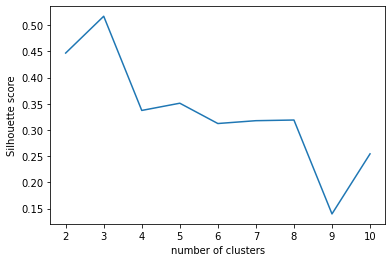

In [139]:
comparison(train, np.arange(2,11), 'tied')

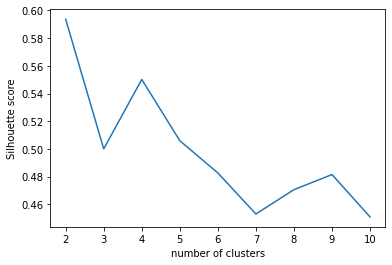

In [140]:
comparison(train, np.arange(2,11), 'spherical')

Według Silhuette Score optymalna liczba klastrów to 2 dla parametru covariance `spherical`.

## Ustawienie tresholdu

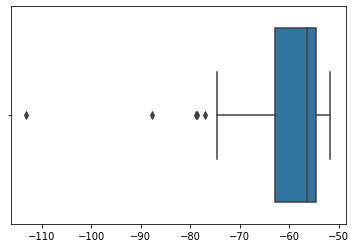

In [141]:
GMM = GaussianMixture(n_components=2, covariance_type='spherical')
GMM.fit(train)
score = GMM.score_samples(train)
sns.boxplot(score)
plt.show()

W zbiorze traningowym nie ma outlierów, więc możemy policzyć treshold.

In [142]:
treshold = floor(min(score)), ceil(max(score))
print(f"Threshold: {treshold}")

Threshold: (-114, -51)


## Outliery w zbiorze walidacyjnym

In [143]:
score_samples_val = GMM.score_samples(val)
outliers_val = []
for i in score_samples_val:
    if i < treshold[0] or i > treshold[1]:
        outliers_val.append(1)
    else:
        outliers_val.append(0)
print('Outliers in validation set:  ', outliers_val)
print('Sum of outliers:  ', sum(outliers_val))

Outliers in validation set:   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Sum of outliers:   2


In [165]:
score_samples_test = GMM.score_samples(test_x)
outliers_test = []
for i in score_samples_test:
    if i < treshold[0] or i > treshold[1]:
        outliers_test.append(1)
    else:
        outliers_test.append(0)
comparison_df = copy.deepcopy(test_y)
comparison_df['predicted'] = outliers_test
print(comparison_df)


    class  predicted
0       0          0
1       0          0
2       0          0
3       0          0
4       0          0
5       0          0
6       0          0
7       0          0
8       0          0
9       0          0
10      0          0
11      0          0
12      1          1
13      1          0
14      1          1
15      1          1
16      1          1


## Metryki

In [148]:
print("Precision score:", precision_score(test_y, outliers_test))
print("F1 score:", f1_score(test_y, outliers_test))
print("Recall score:", recall_score(test_y, outliers_test))

Precision score: 1.0
F1 score: 0.888888888888889
Recall score: 0.8


## Wnioski

Jak widać, model poprawnie zinterpretował 4 z 5 outlierów ze zbioru testowego. Można z tego wywnioskować, że GMM może być stosowany w celu wykrywania outlierów. Ważny w tym procesie jest odpowiedni dobór tresholdu.